# Park Power to the People
## UP 206a Final - Notebook 1 of 2
## Carolyn Chu
I'm working to answer the question of where do we need parks most in Los Angeles? I made an index to rank census tracts looking at different indicators using census data on income, race, and language spoken at home. I chose these based on research that specific groups -- including low-income people, Black and Latinx/Hispanic people, and people who cannot find culturally-appropriate programming -- have less access to parks and recreation services than their counterparts. Using these variables, I give each census tract a score 1-4 to determine park need. I then add them up so that each census tract has a score out of a possible 16 points.

This notebook is divided into the following sections:
1. Income Indicator
2. Race Indicators, specifically Hispanic/Latinx and Black racial groups
3. Language Spoken at Home Indicator
4. Putting the indicator scores together
- What do the parks look like in those census tracts?

In [1]:
# import libraries

import pandas as pd                      # for data wrangling
import geopandas as gpd                  # for analyzing spatial data
import contextily as ctx                 # for base maps
import matplotlib.pyplot as plt          # for plotting data
import numpy as np                       # for math and querying

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# 1. Creating the Indicator for Median Household Income

I'm using Median Household Income data from the American Community Survey 5-Year Data Estimates (2015-2019). I pulled data from censusreporter.org. Maps and plots for this indicator will be colored in the orange family.

In [2]:
# import data
income = gpd.read_file('data/acs2019_5yr_medianincome.geojson')

### Data Cleanup
Note: while putting this notebook together, I often ran codes such as .head(), .tail(), and .info() to make sure I was running appropriate code, though I removed many of these checks while cleaning up the notebook to keep things tidy. I just want to assure the reader that I checked often to make sure my data didn't look wonky!

In [3]:
# drop the last row, which is for all of LA city
income = income.drop([1004])

In [4]:
# rename the third and fourth column to Median Household Income and Margin of Error
# refer to metadata for any clarification needed

income.columns = ['geoid', 'name', 'Median Household Income', 'Margin of Error', 'geometry']

### Descriptive Statistics

In [5]:
# get basic statistics
income['Median Household Income'].describe()

count       992.000000
mean      68203.515121
std       36642.300370
min        9191.000000
25%       42758.000000
50%       58398.500000
75%       85267.500000
max      250001.000000
Name: Median Household Income, dtype: float64

Text(0.5, 1.0, 'Median Household Income in Los Angeles')

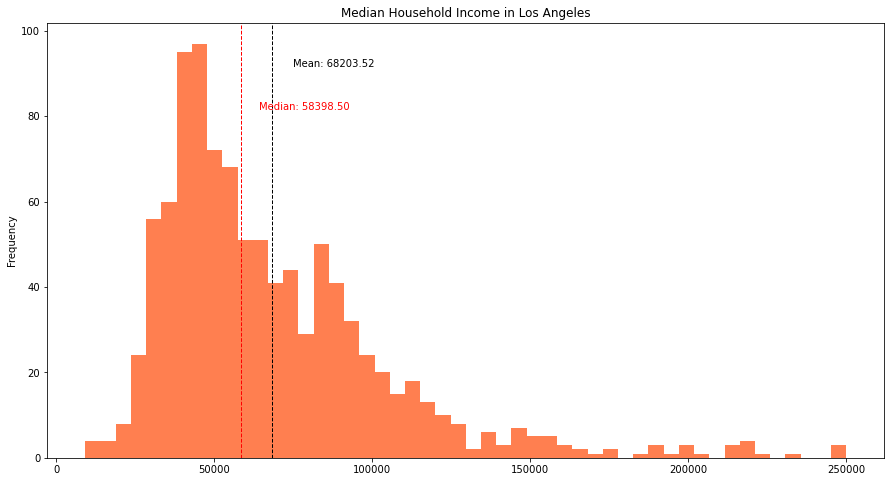

In [6]:
#plot as a histogram

income['Median Household Income'].plot.hist(figsize=(15,8),
                                           bins=50,
                                           color='coral'
                                  )
plt.axvline(income['Median Household Income'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(income['Median Household Income'].median(), color='r', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(income['Median Household Income'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(income['Median Household Income'].mean()))
plt.text(income['Median Household Income'].median()*1.1, max_ylim*0.8, 'Median: {:.2f}'.format(income['Median Household Income'].median()),color='r')
plt.title('Median Household Income in Los Angeles')

### Rank Census Tracts 1-4 Based on Median Household Income (MHI)
I'm classifying the census tracts by quartiles. They will receive a score of 1-4, with 1 representing highest MHI (and corresponding to less park need) and 4 representing lowest MHI (and thereofre more park need).

In [7]:
# adding a column with conditions using numpy

# create a list of conditions
conditions = [
    (income['Median Household Income'] <= 42758.00),
    (income['Median Household Income'] > 42758.00) & (income['Median Household Income'] <= 58398.50),
    (income['Median Household Income'] > 58398.50) & (income['Median Household Income'] <= 85267.50),
    (income['Median Household Income'] > 85267.50)
]

# create a list of values we want to assign for each condition
values = ['4', '3', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
income ['MHI Indicator'] = np.select(conditions, values)

income.sample(5)


,geoid,name,Median Household Income,Margin of Error,geometry,MHI Indicator
217,14000US06037127210,"Census Tract 1272.10, Los Angeles, CA",55997.0,4349.0,"MULTIPOLYGON (((-118.46620 34.21422, -118.4661...",3
30,14000US06037104701,"Census Tract 1047.01, Los Angeles, CA",35357.0,6270.0,"MULTIPOLYGON (((-118.42190 34.26624, -118.4213...",4
568,14000US06037209401,"Census Tract 2094.01, Los Angeles, CA",30926.0,4075.0,"MULTIPOLYGON (((-118.28423 34.05683, -118.2842...",4
412,14000US06037189905,"Census Tract 1899.05, Los Angeles, CA",72837.0,19383.0,"MULTIPOLYGON (((-118.35394 34.10347, -118.3534...",2
989,14000US06037980008,"Census Tract 9800.08, Los Angeles, CA",NaN,NaN,"MULTIPOLYGON (((-118.50267 34.22121, -118.5015...",0


Text(0.5, 1.0, 'Indicator for Median Household Income in Los Angeles')

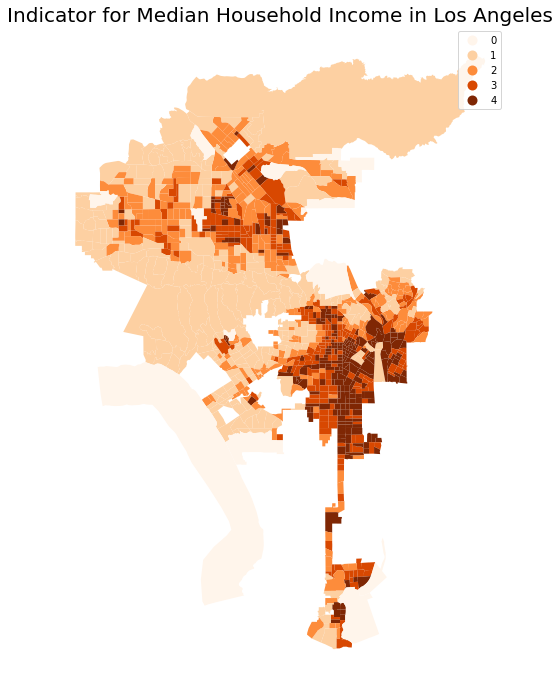

In [8]:
# map the indicator
fig, ax = plt.subplots(figsize=(12, 12))

income.plot(ax=ax,
            column='MHI Indicator',
            legend=True,
            cmap='Oranges'
           )

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Indicator for Median Household Income in Los Angeles',fontsize=20,pad=5)

### Final Data Cleanup for this Indicator
I'm happy with the results so I'm going to do a bit of cleanup and create a new gdf with just the most essential information. I'm going to add the other indicators to this gdf toward the end of this notebook.

In [9]:
# list column names
income.columns.tolist()

['geoid',
 'name',
 'Median Household Income',
 'Margin of Error',
 'geometry',
 'MHI Indicator']

In [10]:
# decide which columns I want to keep

income_keepcolumns = ['geoid',
 'name',
 'geometry',
 'MHI Indicator']

# make a copy gdf of just those columns
inc = income[income_keepcolumns].copy()
inc.tail()

,geoid,name,geometry,MHI Indicator
999,14000US06037980024,"Census Tract 9800.24, Los Angeles, CA","MULTIPOLYGON (((-118.51849 34.18389, -118.5184...",1
1000,14000US06037980026,"Census Tract 9800.26, Los Angeles, CA","MULTIPOLYGON (((-118.35173 34.28034, -118.3517...",0
1001,14000US06037980028,"Census Tract 9800.28, Los Angeles, CA","MULTIPOLYGON (((-118.45246 33.94315, -118.4464...",0
1002,14000US06037980031,"Census Tract 9800.31, Los Angeles, CA","MULTIPOLYGON (((-118.29105 33.75378, -118.2905...",0
1003,14000US06037990200,"Census Tract 9902, Los Angeles, CA","MULTIPOLYGON (((-118.63598 34.03255, -118.6325...",0


# 2. Creating the Indicators for Race (Hispanic/Latinx and Black/African American)

I'm using "Hispanic or Latino Origin by Race" data from the American Community Survey 5-Year Data Estimates (2015-2019). I pulled data from censusreporter.org. Maps and plots for the Hispanic/Latinx Indicator will be colored in greens and Black/African American will be in purples.

In [11]:
race_fulldata = gpd.read_file('data/acs2019_5yr_race.geojson')

### Data Cleanup

In [12]:
# keep only necessary columns

race_trimmed_keepcolumns = ['geoid',
 'name',
 'B03002001',
 'B03002004',
 'B03002012',
 'geometry']

# create a copy gdf of just this subset

race_trimmed = race_fulldata[race_trimmed_keepcolumns].copy()

In [13]:
#rename columns for clarity

race_trimmed.columns = ['geoid',
 'name',
 'Total',
 'Non Hispanic Black',
 'Hispanic',
 'geometry']

In [14]:
# normalize the data

race_trimmed['Percent Non Hispanic Black'] = race_trimmed['Non Hispanic Black']/race_trimmed['Total']*100
race_trimmed['Percent Hispanic'] = race_trimmed['Hispanic']/race_trimmed['Total']*100

In [15]:
# check the data
race_trimmed.tail(3)

,geoid,name,Total,Non Hispanic Black,Hispanic,geometry,Percent Non Hispanic Black,Percent Hispanic
1002,14000US06037980031,"Census Tract 9800.31, Los Angeles, CA",1175.0,232.0,387.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905...",19.744681,32.936170
1003,14000US06037990200,"Census Tract 9902, Los Angeles, CA",0.0,0.0,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325...",NaN,NaN
1004,16000US0644000,"Los Angeles, CA",3966936.0,341750.0,1922409.0,"MULTIPOLYGON (((-118.66818 34.18987, -118.6681...",8.614961,48.460802


In [16]:
# drop la city row
race_trimmed = race_trimmed.drop([1004])

### Descriptive Statistics for Hispanic/Latinx Data

In [17]:
race_trimmed['Percent Hispanic'].describe()

count    999.000000
mean      47.709974
std       28.618584
min        0.000000
25%       20.043632
50%       48.353068
75%       72.132209
max      100.000000
Name: Percent Hispanic, dtype: float64

Text(0.5, 1.0, 'Percent of Hispanic/Latinx Population')

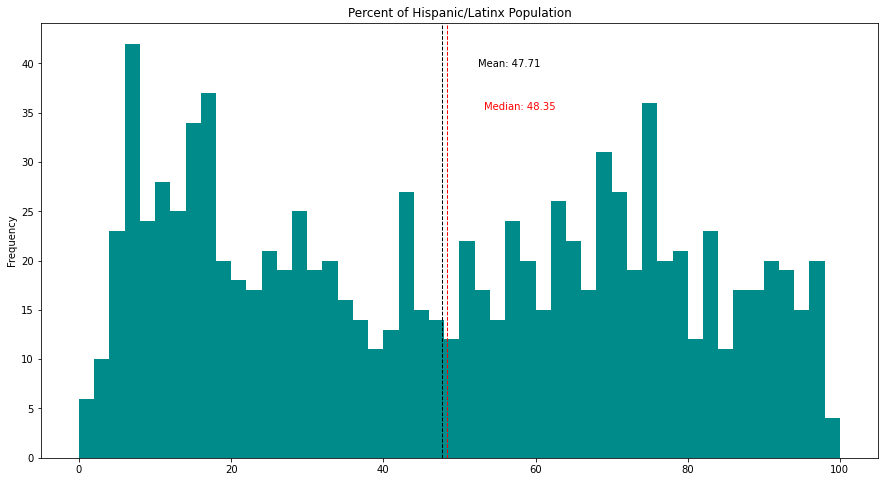

In [18]:
# histogram

race_trimmed['Percent Hispanic'].plot.hist(figsize=(15,8),
                                           bins=50,
                                           color='darkcyan'
                                  )

# add lines and text for the mean and median
plt.axvline(race_trimmed['Percent Hispanic'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(race_trimmed['Percent Hispanic'].median(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(race_trimmed['Percent Hispanic'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(race_trimmed['Percent Hispanic'].mean()))
plt.text(race_trimmed['Percent Hispanic'].median()*1.1, max_ylim*0.8, 'Median: {:.2f}'.format(race_trimmed['Percent Hispanic'].median()),color='r')

# add a title
plt.title('Percent of Hispanic/Latinx Population')

Text(0.5, 1.0, 'Percent of Hispanic/Latinx Population, Natural Breaks')

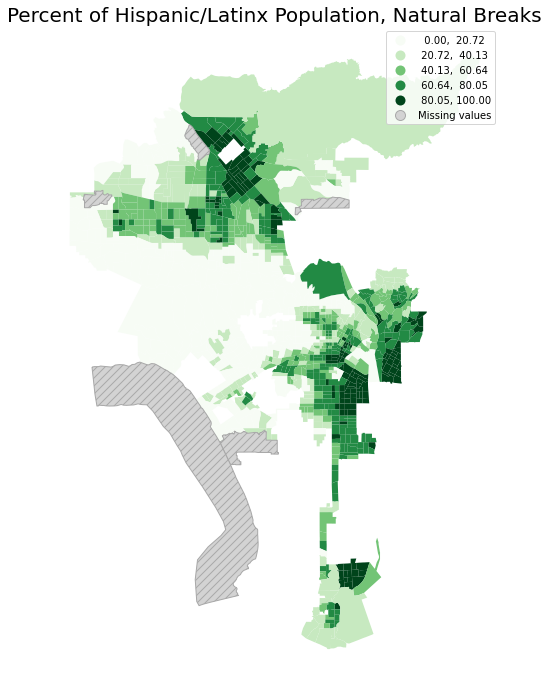

In [19]:
# plot using natural breaks to see how it compares to quantiles
race_trimmed.plot(figsize=(12,12),
          column='Percent Hispanic',
          legend=True,
          scheme='naturalbreaks',
          cmap='Greens',
          missing_kwds={
                     "color": "lightgrey",
                     "edgecolor": "darkgrey",
                     "hatch": "///",
                     "label": "Missing values"
                 }
         )
plt.axis('off')
plt.title('Percent of Hispanic/Latinx Population, Natural Breaks',fontsize=20,pad=5)

Using the information in the legend to understand Natural Breaks classification, it looks like the data were divided similarly to quantiles. I'm going to continue using quantiles for this indicator.

### Rank Census Tracts 1-4 Based on Percentage of Hispanic/Latinx Population
Tracts given a score of 4 have a higher percentage of Hispanic/Latinx population and tracts given a score of 1 have a smaller percentage of Hispanic/Latinx population.

In [20]:
# add a column of indicators for Hispanic race data

# create a list of conditions
race_conditions = [
    (race_trimmed['Percent Hispanic'] >= 72.132209),
    (race_trimmed['Percent Hispanic'] < 72.132209) & (race_trimmed['Percent Hispanic'] >= 48.353068),
    (race_trimmed['Percent Hispanic'] < 48.353068) & (race_trimmed['Percent Hispanic'] >= 20.043632),
    (race_trimmed['Percent Hispanic'] < 20.043632)
]

# create a list of values we want to assign for each condition
race_values = ['4', '3', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
race_trimmed ['Hispanic Population Indicator'] = np.select(race_conditions, race_values)

race_trimmed.sample(3)

,geoid,name,Total,Non Hispanic Black,Hispanic,geometry,Percent Non Hispanic Black,Percent Hispanic,Hispanic Population Indicator
942,14000US06037291300,"Census Tract 2913, Los Angeles, CA",3037.0,289.0,748.0,"MULTIPOLYGON (((-118.30915 33.86086, -118.3091...",9.515970,24.629569,2
268,14000US06037133000,"Census Tract 1330, Los Angeles, CA",4778.0,26.0,2468.0,"MULTIPOLYGON (((-118.56225 34.20096, -118.5578...",0.544161,51.653411,3
978,14000US06037297110,"Census Tract 2971.10, Los Angeles, CA",4649.0,515.0,2988.0,"MULTIPOLYGON (((-118.28793 33.73241, -118.2879...",11.077651,64.271886,3


(-118.69760045, -118.05026255000001, 33.6616443, 34.437775699999996)

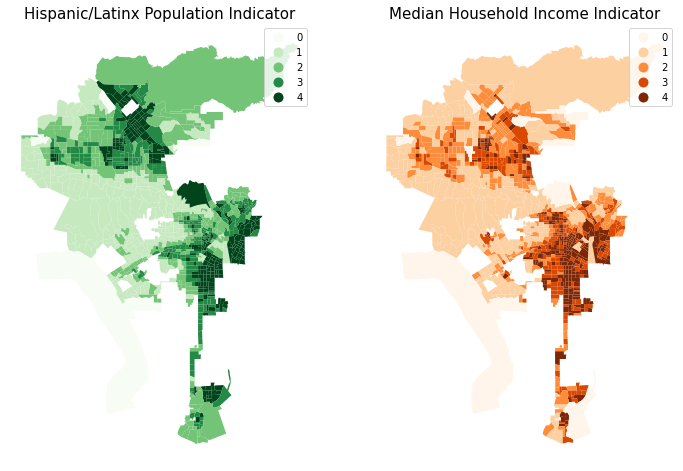

In [21]:
# subplots, 1 row and 2 columns of plots

fig,ax = plt.subplots(1,2,figsize=(12,12))

# for the subplot on the left
race_trimmed.plot(ax=ax[0],
                  column='Hispanic Population Indicator',
                  legend=True,
                  cmap='Greens'
                 )

ax[0].set_title('Hispanic/Latinx Population Indicator', fontsize=15,pad=5)
ax[0].axis('off');           

# for the subplot on the right
inc.plot(ax=ax[1],
         column='MHI Indicator',
         legend=True,
         cmap='Oranges'
        )

ax[1].set_title('Median Household Income Indicator',fontsize=15,pad=5)
ax[1].axis('off')

I wanted to see these two side-by-side. There's definitely some overlap of the darkest colored census tracts (particularly in downtown and Northeast LA). There's some contrast in the San Fernando Valley region.

### Descriptive Statistics for Black Population Data

In [22]:
race_trimmed['Percent Non Hispanic Black'].describe()

count    999.000000
mean       8.295381
std       11.891175
min        0.000000
25%        1.758696
50%        4.358740
75%        8.310453
max       82.157870
Name: Percent Non Hispanic Black, dtype: float64

Text(4.794614331355546, 199.92000000000002, 'Median: 4.36')

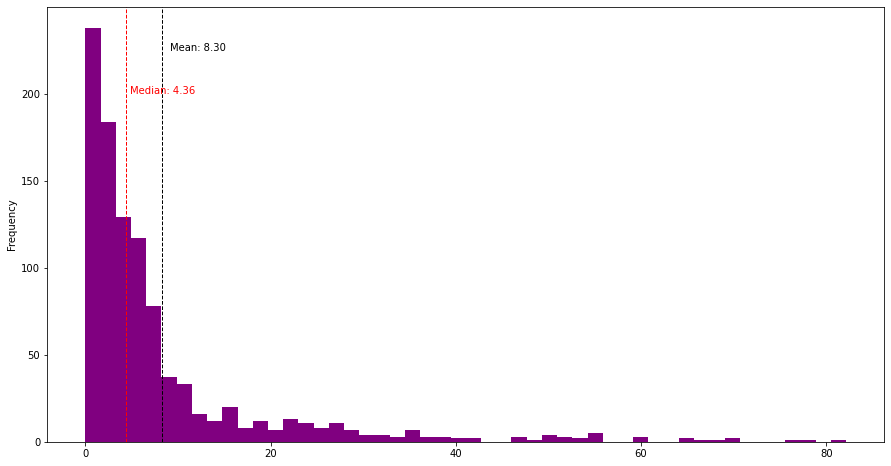

In [23]:
# histogram
race_trimmed['Percent Non Hispanic Black'].plot.hist(figsize=(15,8),
                                           bins=50,
                                           color='purple'
                                  )

# add mean and median lines
plt.axvline(race_trimmed['Percent Non Hispanic Black'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(race_trimmed['Percent Non Hispanic Black'].median(), color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(race_trimmed['Percent Non Hispanic Black'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(race_trimmed['Percent Non Hispanic Black'].mean()))
plt.text(race_trimmed['Percent Non Hispanic Black'].median()*1.1, max_ylim*0.8, 'Median: {:.2f}'.format(race_trimmed['Percent Non Hispanic Black'].median()),color='r')

This data is very skewed! This hints at how racial segregation continues across Los Angeles.

Text(0.5, 1.0, 'Percent Black Population, Natural Breaks')

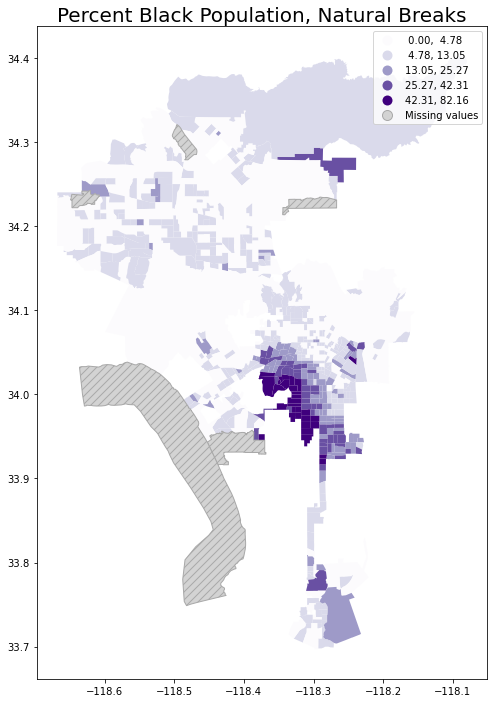

In [24]:
# plot using natural breaks to see how it compares to quantiles

race_trimmed.plot(figsize=(12,12),
          column='Percent Non Hispanic Black',
          legend=True,
          scheme='naturalbreaks',
          cmap='Purples',
          missing_kwds={
                     "color": "lightgrey",
                     "edgecolor": "darkgrey",
                     "hatch": "///",
                     "label": "Missing values"
                 }
         )
plt.title('Percent Black Population, Natural Breaks',fontsize=20,pad=5)

### Rank Census Tracts 1-4 Based on Percentage of Black/African American Population
The Black LA population seems to be centered around South LA. I have decided not to use quantiles for this category, mostly because I feel like an equal spread of tracts in the 1-4 rankings wouldn't properly represent the segregation of neighborhoods. I'm using the mean and median as cutoffs for scores of 1 and 2, and I'm giving a score of 4 to tracts that are majority Black (i.e. population of Black residents at 50% or more).

In [25]:
#create indicator for Black race data

# create a list of conditions
black_conditions = [
    (race_trimmed['Percent Non Hispanic Black'] >= 50),
    (race_trimmed['Percent Non Hispanic Black'] < 50) & (race_trimmed['Percent Non Hispanic Black'] >= 8.310453),
    (race_trimmed['Percent Non Hispanic Black'] < 8.310453) & (race_trimmed['Percent Non Hispanic Black'] >= 4.36),
    (race_trimmed['Percent Non Hispanic Black'] < 4.36)
]

# create a list of values we want to assign for each condition
black_values = ['4', '3', '2', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
race_trimmed['Black Population Indicator'] = np.select(black_conditions, black_values)

race_trimmed.sample(3)

,geoid,name,Total,Non Hispanic Black,Hispanic,geometry,Percent Non Hispanic Black,Percent Hispanic,Hispanic Population Indicator,Black Population Indicator
44,14000US06037106406,"Census Tract 1064.06, Los Angeles, CA",5839.0,60.0,4014.0,"MULTIPOLYGON (((-118.47073 34.32430, -118.4706...",1.027573,68.744648,3,1
613,14000US06037212800,"Census Tract 2128, Los Angeles, CA",3543.0,500.0,1135.0,"MULTIPOLYGON (((-118.33697 34.04874, -118.3360...",14.112334,32.034999,2,3
743,14000US06037232600,"Census Tract 2326, Los Angeles, CA",6833.0,1366.0,5300.0,"MULTIPOLYGON (((-118.30452 33.98915, -118.3044...",19.991219,77.564759,4,3


(-118.69760045, -118.05026255000001, 33.6616443, 34.437775699999996)

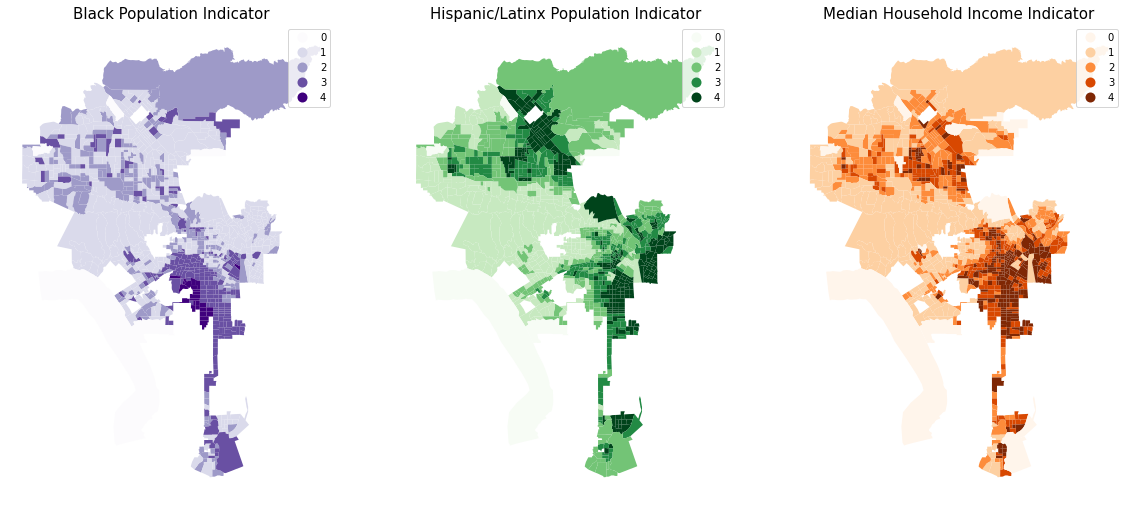

In [26]:
# subplots, 1 row and 3 columns of plots

fig,ax = plt.subplots(1,3,figsize=(20,20))

# for the first subplot
race_trimmed.plot(ax=ax[0],
         column='Black Population Indicator',
         legend=True,
         cmap='Purples'
        )

ax[0].set_title('Black Population Indicator',fontsize=15,pad=5)
ax[0].axis('off')

# for the subplot on the left
race_trimmed.plot(ax=ax[1],
                  column='Hispanic Population Indicator',
                  legend=True,
                  cmap='Greens'
                 )

ax[1].set_title('Hispanic/Latinx Population Indicator', fontsize=15,pad=5)
ax[1].axis('off');           

# for the subplot on the right
inc.plot(ax=ax[2],
         column='MHI Indicator',
         legend=True,
         cmap='Oranges'
        )

ax[2].set_title('Median Household Income Indicator',fontsize=15,pad=5)
ax[2].axis('off')



### Final Data Cleaup for these 2 Race Indicators

In [27]:
race_trimmed.columns.tolist()

['geoid',
 'name',
 'Total',
 'Non Hispanic Black',
 'Hispanic',
 'geometry',
 'Percent Non Hispanic Black',
 'Percent Hispanic',
 'Hispanic Population Indicator',
 'Black Population Indicator']

In [28]:
# drop unnecessary columns, keep things mean and clean
# i dropped the geometry column because i'm going to join to the income gdf which already has a geometry column

race_keepcolumns = ['geoid',
 'Hispanic Population Indicator',
 'Black Population Indicator']

race = race_trimmed[race_keepcolumns].copy()

In [29]:
race.head(3)

,geoid,Hispanic Population Indicator,Black Population Indicator
0,14000US06037101110,2,1
1,14000US06037101122,1,1
2,14000US06037101210,2,1


# 3. Creating an Indicator for Language Access
I'm using "Languages Spoken at Home for the Population 5 Years and Over" data from the American Community Survey 5-Year Data Estimates (2015-2019). I got the data from censusreporter.org. I'm going to clean the data to pull percentages of population that speak another language at home **and** speaks English less than "very well". Maps and plots for this indicator will be colored in blues.

I'm using this dataset as a proxy for language access. This [research article on park equity](https://www.tandfonline.com/doi/full/10.1080/13574809.2018.1497927?casa_token=az-pm4CevPUAAAAA%3AzUqXqLBskjZAqDWeEgSM8WypLPrR_hVWcvLfH3TMOKSoJLuPYxTnyo7o_LDzAWzFN4hJSJHE7IQtYRU) examines psychological barriers to park access, or the extent that a park appears safe, welcoming and available for different social groups. [Another study](https://www.sciencedirect.com/science/article/pii/S0016718511001813?casa_token=V3fDx6FTRtUAAAAA:xTVfavdRKgxQOI4KS17opeIMAhNV7mYwAbspCPxpeMAd_5POBrzpqVgpNsUSkQeDp7K7BnWZ4K65) finds that non-English speaking individuals have difficulty accessing parks and recreation services when parks lack information in multiple languages or bilingual staff.



In [30]:
# bring in language data from censusreporter
language_fulldata = gpd.read_file('data/acs2019_5yr_languagespokenathome.geojson')

### Data Cleanup

In [31]:
language_fulldata.columns.tolist()

['geoid',
 'name',
 'C16001001',
 'C16001001, Error',
 'C16001002',
 'C16001002, Error',
 'C16001003',
 'C16001003, Error',
 'C16001004',
 'C16001004, Error',
 'C16001005',
 'C16001005, Error',
 'C16001006',
 'C16001006, Error',
 'C16001007',
 'C16001007, Error',
 'C16001008',
 'C16001008, Error',
 'C16001009',
 'C16001009, Error',
 'C16001010',
 'C16001010, Error',
 'C16001011',
 'C16001011, Error',
 'C16001012',
 'C16001012, Error',
 'C16001013',
 'C16001013, Error',
 'C16001014',
 'C16001014, Error',
 'C16001015',
 'C16001015, Error',
 'C16001016',
 'C16001016, Error',
 'C16001017',
 'C16001017, Error',
 'C16001018',
 'C16001018, Error',
 'C16001019',
 'C16001019, Error',
 'C16001020',
 'C16001020, Error',
 'C16001021',
 'C16001021, Error',
 'C16001022',
 'C16001022, Error',
 'C16001023',
 'C16001023, Error',
 'C16001024',
 'C16001024, Error',
 'C16001025',
 'C16001025, Error',
 'C16001026',
 'C16001026, Error',
 'C16001027',
 'C16001027, Error',
 'C16001028',
 'C16001028, Error',
 

In [32]:
languages_keepcolumns = ['geoid',
 'name',
 'C16001001', #total
 'C16001002', #onlyenglish
 'C16001005', #speaks spanish and english less than "very well"
 'C16001008', #french, haitian, cajun
 'C16001011', #german
 'C16001014', #russian, polish, slavic
 'C16001017', #Indo-european 
 'C16001020', #korean
 'C16001023', #chinese - mandarin and cantonese
 'C16001026', # vietnamese
 'C16001029', #tagalog
 'C16001032', #other asian languages
 'C16001035', # arabic
 'C16001038', #other languages
 'geometry']

language_trimmed = language_fulldata[languages_keepcolumns].copy()
language_trimmed.sample(3)

,geoid,name,C16001001,C16001002,C16001005,C16001008,C16001011,C16001014,C16001017,C16001020,C16001023,C16001026,C16001029,C16001032,C16001035,C16001038,geometry
710,14000US06037228220,"Census Tract 2282.20, Los Angeles, CA",4122.0,571.0,1535.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-118.25649 34.00666, -118.2537..."
699,14000US06037224600,"Census Tract 2246, Los Angeles, CA",3159.0,422.0,1397.0,0.0,0.0,0.0,0.0,5.0,23.0,0.0,7.0,13.0,0.0,0.0,"MULTIPOLYGON (((-118.27799 34.02105, -118.2776..."
685,14000US06037222001,"Census Tract 2220.01, Los Angeles, CA",2985.0,1321.0,713.0,0.0,0.0,0.0,0.0,10.0,3.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-118.31766 34.03083, -118.3151..."


In [33]:
#rename columns

language_trimmed.columns = ['geoid',
 'name',
 'Total',
 'Speak only English',
 'Speaks Spanish and English less than well',
 'Speaks French Haitian Cajun and English less than well',
 'Speaks German and English less than well',
 'Speaks Russian Polish Slavic and English less than well',
 'Speaks Indo European and English less than well',
 'Speaks Korean and English less than well',
 'Speaks Chinese and English less than well',
 'Speaks Vietnamese and English less than well',
 'Speaks Tagalog and English less than well',
 'Speaks Other Asian Languages and English less than well',
 'Speaks Arabic and English less than well',
 'Speaks Other Language and English less than well',
 'geometry']

In [34]:
# drop the LA city row
language_trimmed = language_trimmed.drop([1004])

In [35]:
# sum up the "speak english less than well" columns
language_trimmed['Total Speak English less than well'] = language_trimmed['Speaks Spanish and English less than well'] + language_trimmed['Speaks French Haitian Cajun and English less than well'] + language_trimmed['Speaks German and English less than well'] + language_trimmed['Speaks Russian Polish Slavic and English less than well'] + language_trimmed['Speaks Indo European and English less than well'] + language_trimmed['Speaks Korean and English less than well'] + language_trimmed['Speaks Chinese and English less than well'] + language_trimmed['Speaks Vietnamese and English less than well'] + language_trimmed['Speaks Tagalog and English less than well'] + language_trimmed['Speaks Other Asian Languages and English less than well'] + language_trimmed['Speaks Arabic and English less than well'] + language_trimmed['Speaks Other Language and English less than well']

In [36]:
#normalize the data
language_trimmed['Percent English less than well Speakers'] = language_trimmed['Total Speak English less than well']/language_trimmed['Total']*100
language_trimmed['Percent English Only Speakers'] = language_trimmed['Speak only English']/language_trimmed['Total']*100

### Descriptive Statistics for Language Data

In [37]:
language_trimmed['Percent English less than well Speakers'].describe()

count    999.000000
mean      25.471426
std       14.928414
min        0.000000
25%       12.624330
50%       25.577437
75%       36.481506
max       70.171615
Name: Percent English less than well Speakers, dtype: float64

Text(28.13518113299295, 68.04, 'Median: 25.58')

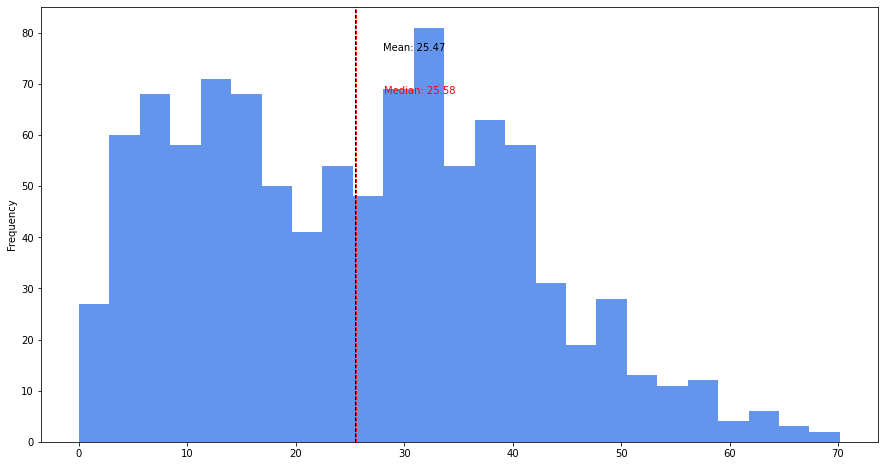

In [38]:
#histogram

language_trimmed['Percent English less than well Speakers'].plot.hist(figsize=(15,8),
                                           bins=25,
                                           color='cornflowerblue'
                                  )

plt.axvline(language_trimmed['Percent English less than well Speakers'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(language_trimmed['Percent English less than well Speakers'].median(), color='r', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(language_trimmed['Percent English less than well Speakers'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(language_trimmed['Percent English less than well Speakers'].mean()))
plt.text(language_trimmed['Percent English less than well Speakers'].median()*1.1, max_ylim*0.8, 'Median: {:.2f}'.format(language_trimmed['Percent English less than well Speakers'].median()),color='r')

Text(0.5, 1.0, 'Language: Speaks English Less Than "Very Well", Natural Breaks')

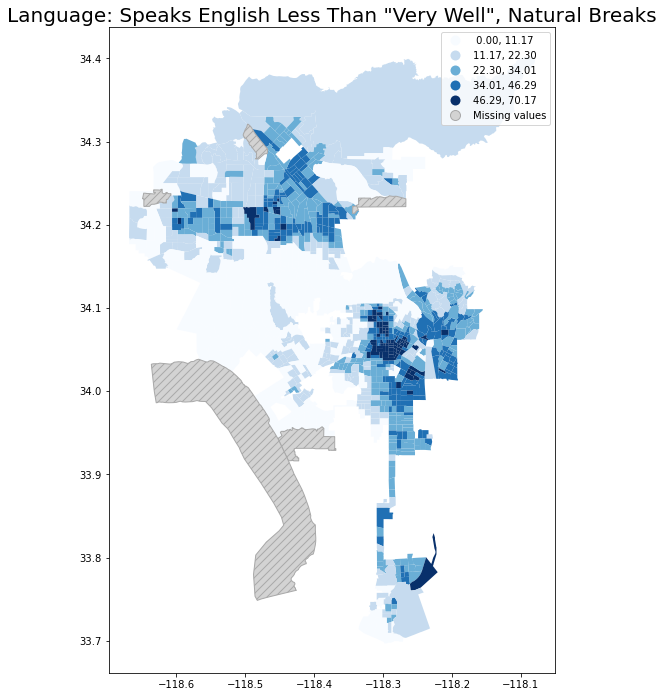

In [39]:
# using matplotlib, visualize the data

language_trimmed.plot(figsize=(8,16),
                 column='Percent English less than well Speakers',
                 legend=True, 
                 scheme='naturalbreaks',
                 cmap='Blues',
                 missing_kwds={
                     "color": "lightgrey",
                     "edgecolor": "darkgrey",
                     "hatch": "///",
                     "label": "Missing values"
                 }
          )
plt.title('Language: Speaks English Less Than "Very Well", Natural Breaks',fontsize=20,pad=5)

Looking at the histogram and choropleth map, I think a mix of quantiles and that natural break at the 46% are good divisions for this data and indicators.
### Rank Census Tracts 1-4 Based on Percentage of People Who Said They Speak English Less Than "Very Well"

In [40]:
lang_conditions = [
    (language_trimmed['Percent English less than well Speakers'] <= 12.624330),
    (language_trimmed['Percent English less than well Speakers'] > 12.624330) & (language_trimmed['Percent English less than well Speakers'] <= 25.577437),
    (language_trimmed['Percent English less than well Speakers'] >= 25.577437) & (language_trimmed['Percent English less than well Speakers'] <= 46.290000),
    (language_trimmed['Percent English less than well Speakers'] > 46.290000)
]

# create a list of values we want to assign for each condition
lang_values = ['1', '2', '3', '4']

# create a new column and use np.select to assign values to it using our lists as arguments
language_trimmed['Language Access Indicator'] = np.select(lang_conditions, lang_values)

language_trimmed.head()

,geoid,name,Total,Speak only English,Speaks Spanish and English less than well,Speaks French Haitian Cajun and English less than well,Speaks German and English less than well,Speaks Russian Polish Slavic and English less than well,Speaks Indo European and English less than well,Speaks Korean and English less than well,...,Speaks Vietnamese and English less than well,Speaks Tagalog and English less than well,Speaks Other Asian Languages and English less than well,Speaks Arabic and English less than well,Speaks Other Language and English less than well,geometry,Total Speak English less than well,Percent English less than well Speakers,Percent English Only Speakers,Language Access Indicator
0,14000US06037101110,"Census Tract 1011.10, Los Angeles, CA",4000.0,2085.0,334.0,0.0,0.0,28.0,296.0,22.0,...,0.0,68.0,0.0,0.0,12.0,"MULTIPOLYGON (((-118.30229 34.25870, -118.3009...",768.0,19.200000,52.125000,2
1,14000US06037101122,"Census Tract 1011.22, Los Angeles, CA",3327.0,2172.0,0.0,0.0,0.0,0.0,221.0,100.0,...,0.0,19.0,0.0,0.0,0.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033...",340.0,10.219417,65.284040,1
2,14000US06037101210,"Census Tract 1012.10, Los Angeles, CA",5925.0,1581.0,933.0,0.0,0.0,0.0,981.0,123.0,...,34.0,0.0,0.0,30.0,0.0,"MULTIPOLYGON (((-118.29945 34.25598, -118.2979...",2101.0,35.459916,26.683544,3
3,14000US06037101220,"Census Tract 1012.20, Los Angeles, CA",3564.0,1246.0,378.0,0.0,0.0,27.0,597.0,65.0,...,0.0,17.0,12.0,11.0,0.0,"MULTIPOLYGON (((-118.28593 34.25227, -118.2859...",1107.0,31.060606,34.960718,3
4,14000US06037101300,"Census Tract 1013, Los Angeles, CA",3795.0,1837.0,38.0,0.0,0.0,0.0,581.0,85.0,...,0.0,9.0,0.0,0.0,0.0,"MULTIPOLYGON (((-118.27822 34.25068, -118.2782...",722.0,19.025033,48.405797,2


### Final Data Cleanup for This Indicator

In [41]:
lang_newkeepcolumns = ['geoid',
 'Language Access Indicator']

language = language_trimmed[lang_newkeepcolumns].copy()

In [42]:
language.sample(3)

,geoid,Language Access Indicator
793,14000US06037239701,3
6,14000US06037102103,1
530,14000US06037206010,3


Look at all four indicators together. I'm going to rearrange the order differently than they were listed out above.

(-118.69760045, -118.05026255000001, 33.6616443, 34.437775699999996)

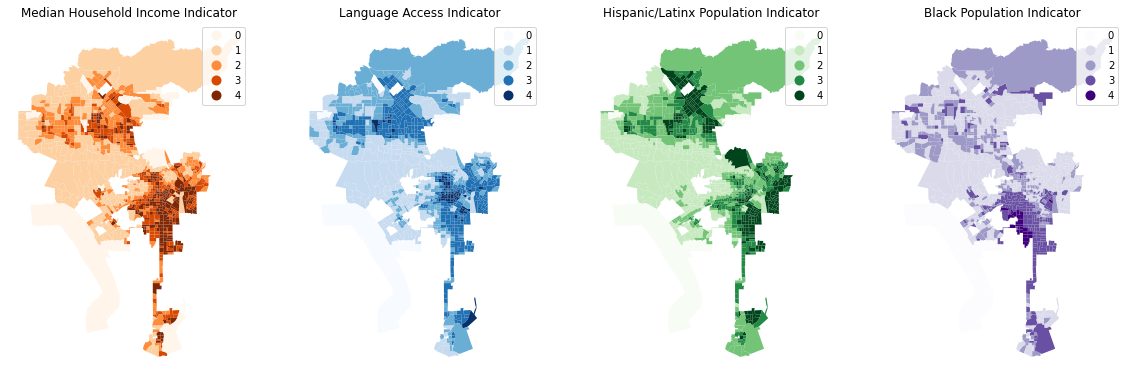

In [43]:
# subplots, 1 rows and 4 columns of plots

fig,ax = plt.subplots(1,4,figsize=(20,20))

# for the first subplot
inc.plot(ax=ax[0],
         column='MHI Indicator',
         legend=True,
         cmap='Oranges'
        )

ax[0].set_title('Median Household Income Indicator',fontsize=12,pad=5)
ax[0].axis('off')

# for the second subplot
language_trimmed.plot(ax=ax[1],
         column='Language Access Indicator',
         legend=True,
         cmap='Blues'
        )

ax[1].set_title('Language Access Indicator',fontsize=12,pad=5)
ax[1].axis('off')




# for the third subplot
race_trimmed.plot(ax=ax[2],
                  column='Hispanic Population Indicator',
                  legend=True,
                  cmap='Greens'
                 )

ax[2].set_title('Hispanic/Latinx Population Indicator', fontsize=12,pad=5)
ax[2].axis('off');           

# for the fourth subplot
race_trimmed.plot(ax=ax[3],
         column='Black Population Indicator',
         legend=True,
         cmap='Purples'
        )

ax[3].set_title('Black Population Indicator',fontsize=12,pad=5)
ax[3].axis('off')


# 4. Combine Scores for All Indicators
I'm going to combine the 4 gdf's that I created in sections 1-3. Census Tracts can have a score of up to 16, which indicates park access need.

In [44]:
# join by attribute
indicators_firstjoin = inc.merge(race, on='geoid')
indicators = indicators_firstjoin.merge(language, on='geoid')

In [45]:
indicators.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1004 entries, 0 to 1003
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   geoid                          1004 non-null   object  
 1   name                           1004 non-null   object  
 2   geometry                       1004 non-null   geometry
 3   MHI Indicator                  1004 non-null   object  
 4   Hispanic Population Indicator  1004 non-null   object  
 5   Black Population Indicator     1004 non-null   object  
 6   Language Access Indicator      1004 non-null   object  
dtypes: geometry(1), object(6)
memory usage: 62.8+ KB


In [46]:
indicators.sample(3)

,geoid,name,geometry,MHI Indicator,Hispanic Population Indicator,Black Population Indicator,Language Access Indicator
978,14000US06037297110,"Census Tract 2971.10, Los Angeles, CA","MULTIPOLYGON (((-118.28793 33.73241, -118.2879...",4,3,3,2
505,14000US06037201602,"Census Tract 2016.02, Los Angeles, CA","MULTIPOLYGON (((-118.17714 34.07733, -118.1751...",3,4,1,3
769,14000US06037237300,"Census Tract 2373, Los Angeles, CA","MULTIPOLYGON (((-118.31775 33.97502, -118.3177...",3,2,4,2


In [47]:
#need to change objects into integers
indicators['MHI Indicator']=indicators['MHI Indicator'].astype(str).astype(int)
indicators['Hispanic Population Indicator']=indicators['Hispanic Population Indicator'].astype(str).astype(int)
indicators['Black Population Indicator']=indicators['Black Population Indicator'].astype(str).astype(int)
indicators['Language Access Indicator']=indicators['Language Access Indicator'].astype(str).astype(int)

In [48]:
# check
indicators.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1004 entries, 0 to 1003
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   geoid                          1004 non-null   object  
 1   name                           1004 non-null   object  
 2   geometry                       1004 non-null   geometry
 3   MHI Indicator                  1004 non-null   int64   
 4   Hispanic Population Indicator  1004 non-null   int64   
 5   Black Population Indicator     1004 non-null   int64   
 6   Language Access Indicator      1004 non-null   int64   
dtypes: geometry(1), int64(4), object(2)
memory usage: 62.8+ KB


In [49]:
# sum up the indicator scores for a total score
indicators['Total Indicator Score'] = indicators['MHI Indicator'] + indicators['Hispanic Population Indicator'] + indicators['Black Population Indicator'] + indicators['Language Access Indicator']

In [50]:
indicators.sample(3)

,geoid,name,geometry,MHI Indicator,Hispanic Population Indicator,Black Population Indicator,Language Access Indicator,Total Indicator Score
485,14000US06037199110,"Census Tract 1991.10, Los Angeles, CA","MULTIPOLYGON (((-118.20284 34.07868, -118.2016...",2,4,1,3,10
874,14000US06037269500,"Census Tract 2695, Los Angeles, CA","MULTIPOLYGON (((-118.40065 34.04654, -118.4005...",1,1,1,1,4
813,14000US06037241202,"Census Tract 2412.02, Los Angeles, CA","MULTIPOLYGON (((-118.29164 33.93820, -118.2893...",4,3,3,2,12


### Project Geodataframes and Layer with LA Neighborhoods

In [51]:
# neighborhood data from LA Times
nh = gpd.read_file("https://s3-us-west-2.amazonaws.com/mappingla.com/downloads/neighborhoods/la_city.json")

In [52]:
nh.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      114 non-null    object  
 1   slug      114 non-null    object  
 2   geometry  114 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 2.8+ KB


In [53]:
# reproject dataframes
indicators_mercator = indicators.to_crs(epsg=3857)
nh_mercator = nh.to_crs(epsg=3857)

# Maps!
First map the park need index now that all indicators have been added together.

Text(0.5, 1.0, 'Los Angeles Park Need Index')

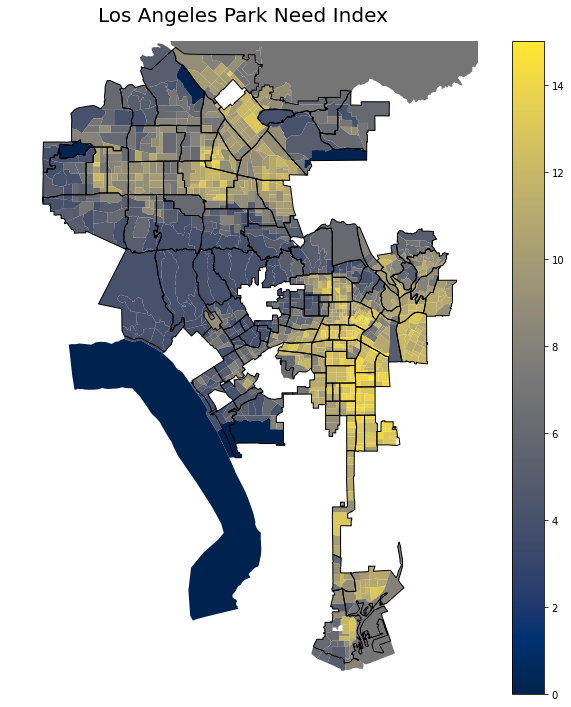

In [54]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
indicators_mercator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='cividis'
        )
nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4075000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Park Need Index',fontsize=20,pad=20)

### Add layer that highlights tracts with highest need

Text(0.5, 1.0, 'Los Angeles Park Need Index (black to yellow)\nand Tracts Scoring 14 or More on a 16-point Index (red)')

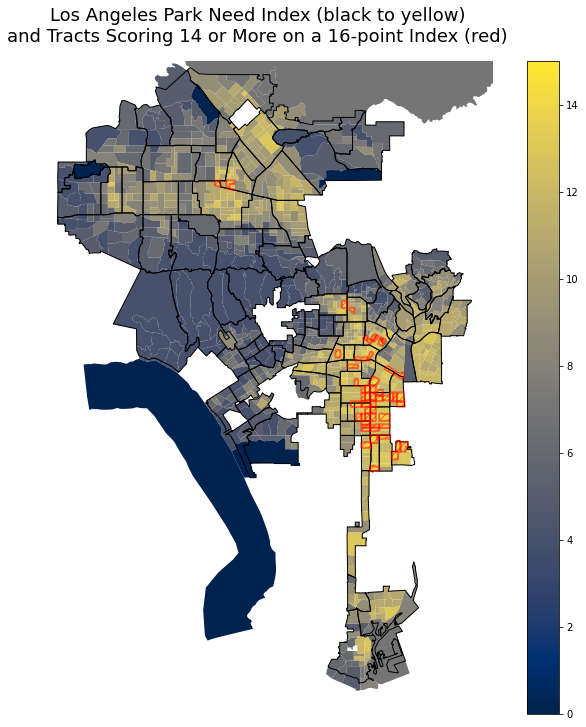

In [55]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
indicators_mercator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='cividis'
        )
nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )
indicators_mercator[indicators_mercator['Total Indicator Score'] >=14].boundary.plot(ax=ax,
        alpha=0.5,
        linewidth=2,
        hatch="///",
        color='red'
        )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4075000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Park Need Index (black to yellow)\n' + 'and Tracts Scoring 14 or More on a 16-point Index (red)',fontsize=18,pad=20)



### Focus in on South LA

Text(0.5, 1.0, 'Highest Scoring Census Tracts are Concentrated in South LA')

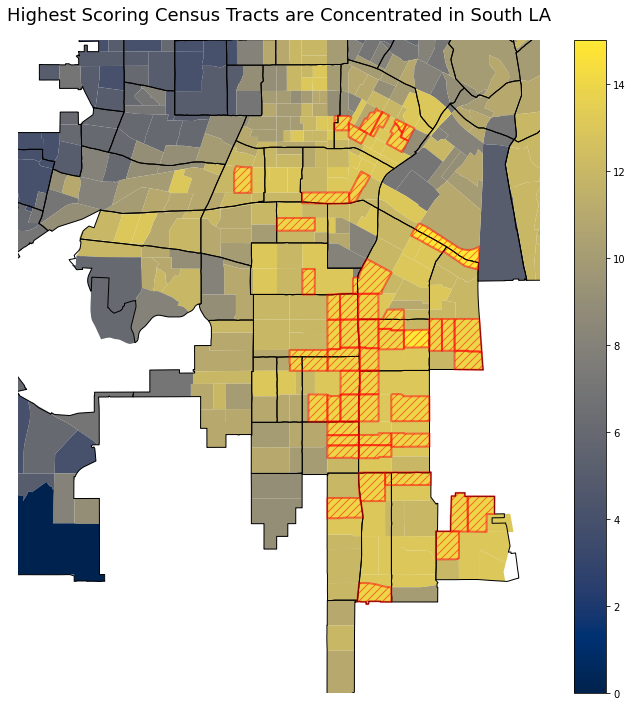

In [56]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
indicators_mercator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='cividis'
        )
nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

indicators_mercator[indicators_mercator['Total Indicator Score'] >=14].boundary.plot(ax=ax,
        alpha=0.5,
        linewidth=2,
        hatch="///",
        color='red'
        )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([4015000, 4040000])
ax.set_xlim([-13180000, -13160000])

# set a title
ax.set_title('Highest Scoring Census Tracts are Concentrated in South LA',fontsize=18,pad=20)

# Parks Data

In [57]:
# add parks data
parks_unprojected = gpd.read_file("https://data.lacity.org/api/geospatial/rwq7-yhp5?method=export&format=GeoJSON")

In [58]:
#project
parks = parks_unprojected.to_crs(epsg=3857)

In [59]:
parks.head(2)

,name,shape_area,objectid,park_id,name_alpha,shape_leng,area_acres,issubpark,region,address,name_publi,park_class,cd_real,geometry
0,Robert F Kennedy Inspiration Memorial Park,6501.37488025,1,1056,ROBERT F KENNEDY PARK (LAUSD) JUA,641.47054538,0.149251627315,N,M,"3400 W Wilshire Blvd, LA 90010",Kennedy (Robert F) Inspiration Memorial Park (...,N,10,"MULTIPOLYGON (((-13168868.269 4037078.847, -13..."
1,Sycamore Grove Park,691462.199493,2,736,SYCAMORE GROVE PARK,6227.3991903,15.8738513625,N,M,"4702 N Figueroa St, LA 90042",Sycamore Grove Park,C,01,"MULTIPOLYGON (((-13158086.069 4042417.355, -13..."


### Add parks data to South LA zoom in

Text(0.5, 1.0, 'Highest Scoring Census Tracts are Concentrated in South LA')

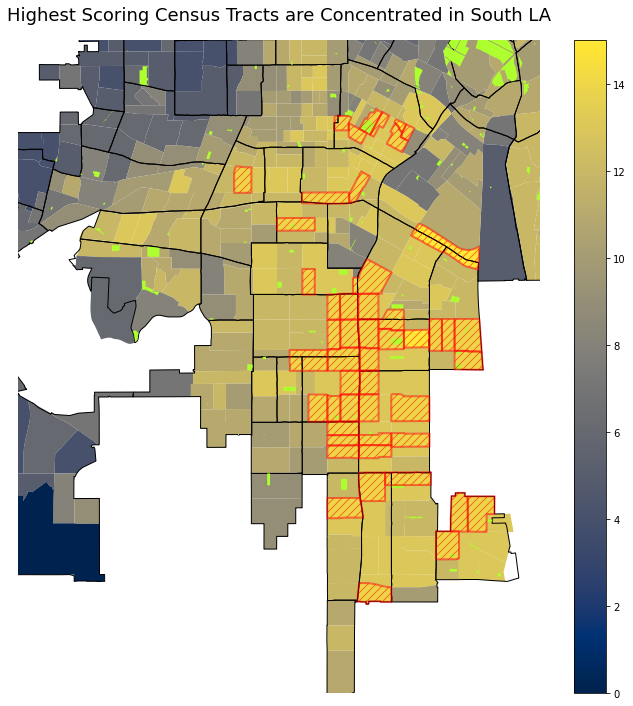

In [60]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
indicators_mercator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='cividis'
        )
nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

indicators_mercator[indicators_mercator['Total Indicator Score'] >=14].boundary.plot(ax=ax,
        alpha=0.5,
        linewidth=2,
        hatch="///",
        color='red'
        )
parks.plot(ax=ax,
                    color="greenyellow"
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([4015000, 4040000])
ax.set_xlim([-13180000, -13160000])

# set a title
ax.set_title('Highest Scoring Census Tracts are Concentrated in South LA',fontsize=18,pad=20)

Text(0.5, 1.0, 'Highest Scoring Census Tracts are Concentrated in South LA')

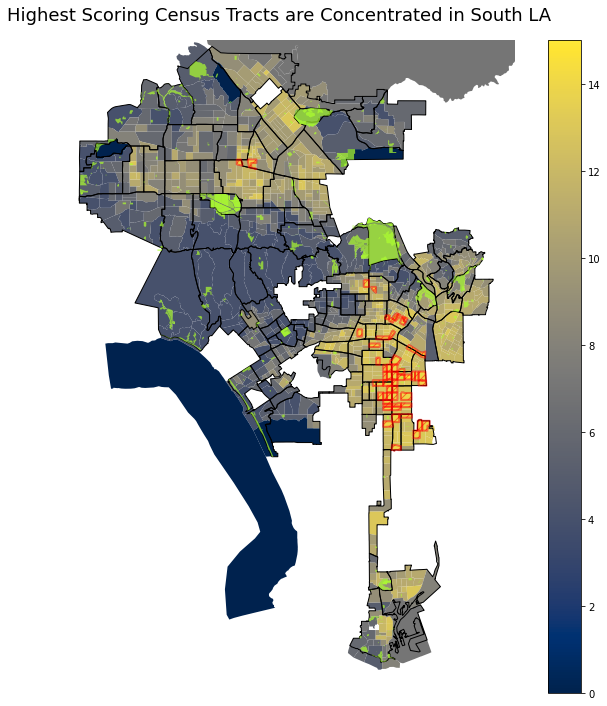

In [61]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
indicators_mercator.plot(ax=ax,
         column='Total Indicator Score',
         legend=True,
         cmap='cividis'
        )
nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

indicators_mercator[indicators_mercator['Total Indicator Score'] >=14].boundary.plot(ax=ax,
        alpha=0.5,
        linewidth=2,
        hatch="///",
        color='red'
        )
parks.plot(ax=ax,
                    color="greenyellow",
           alpha=0.7
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4075000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Highest Scoring Census Tracts are Concentrated in South LA',fontsize=18,pad=20)

### Adding a 1/2 mile buffer
I wanted to learn how to make a buffer. I ultimately decided not to include this in the storymap because I think it inaccurately shows park access. It shows more quantity rather than quality or size of parks.

In [62]:
# half mile buffer
#half a mile is 804.672 meters

parks['buffer'] = parks.buffer(804.672)

In [63]:
parksbuffer = parks.set_geometry("buffer")

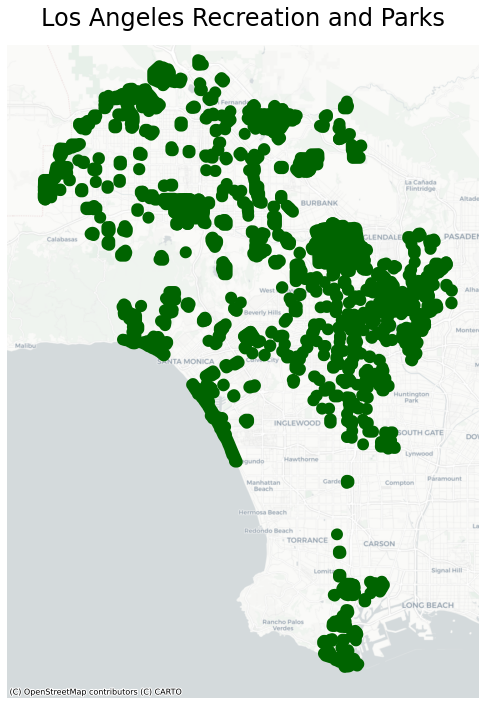

In [64]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 
parksbuffer.plot(ax=ax,
                    color="darkgreen"
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([3985000, 4075000])
ax.set_xlim([-13215000, -13150000])

# set a title
ax.set_title('Los Angeles Recreation and Parks',fontsize=24,pad=20)

# add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

Text(0.5, 1.0, 'Highest Scoring Census Tracts are Concentrated in South LA')

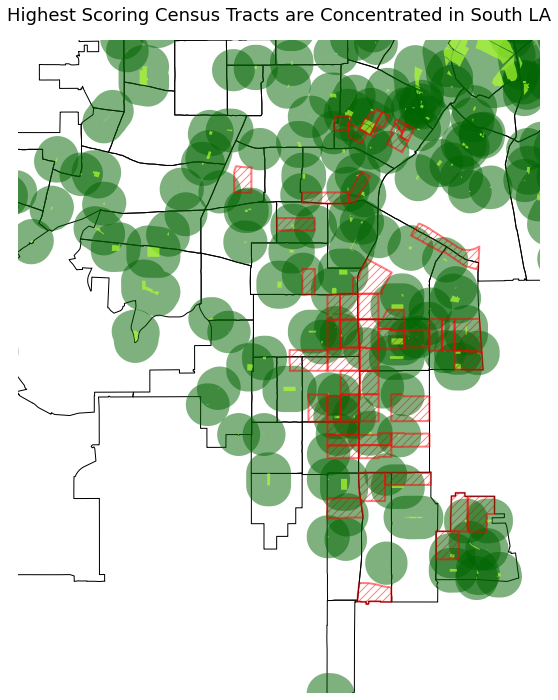

In [65]:
fig, ax = plt.subplots(figsize=(12,12))

# add the layer with ax=ax in the argument 

nh_mercator.plot(ax=ax,
                 facecolor="none",
                 edgecolor="black"
                )

indicators_mercator[indicators_mercator['Total Indicator Score'] >=14].boundary.plot(ax=ax,
        alpha=0.5,
        linewidth=2,
        hatch="///",
        color='red'
        )
parksbuffer.plot(ax=ax,
                    color="darkgreen",
                 alpha=0.5
                   )
parks.plot(ax=ax,
                    color="greenyellow",
           alpha=0.7
                   )

# turn the axis off but set custom axes
ax.axis('off')
ax.set_ylim([4015000, 4040000])
ax.set_xlim([-13180000, -13160000])

# set a title
ax.set_title('Highest Scoring Census Tracts are Concentrated in South LA',fontsize=18,pad=20)